In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

## Basic EDA

In [2]:
profanity = pd.read_csv('profainity.csv')
profanity.groupby('canonical_form_2').count().head()

,text,canonical_form_1,canonical_form_3,category_1,category_2,category_3,severity_rating,severity_description
canonical_form_2,,,,,,,,
arse,6,6,0,6,5,0,6,6
ass,46,46,2,46,38,2,46,46
bastard,2,2,0,2,1,0,2,2
bitch,5,5,0,5,3,0,5,5
butt,8,8,0,8,8,0,8,8


In [3]:
profanity

,text,canonical_form_1,canonical_form_2,canonical_form_3,category_1,category_2,category_3,severity_rating,severity_description
0,69,69,NaN,NaN,sexual anatomy / sexual acts,NaN,NaN,1.0,Mild
1,@55,ass,NaN,NaN,sexual anatomy / sexual acts,NaN,NaN,1.0,Mild
2,@ssfcker,fuck,ass,NaN,sexual anatomy / sexual acts,sexual orientation / gender,NaN,2.8,Severe
3,@ssfucker,fuck,ass,NaN,sexual anatomy / sexual acts,sexual orientation / gender,NaN,2.8,Severe
4,@ssfvcker,fuck,ass,NaN,sexual anatomy / sexual acts,sexual orientation / gender,NaN,2.4,Strong
...,...,...,...,...,...,...,...,...,...
1593,wnker,wank,NaN,NaN,sexual anatomy / sexual acts,other / general insult,NaN,1.0,Mild
1594,wop,wop,NaN,NaN,racial / ethnic slurs,NaN,NaN,2.4,Strong
1595,wophead,wop,NaN,NaN,racial / ethnic slurs,NaN,NaN,2.2,Strong
1596,zip in the wire,zipperhead,NaN,NaN,racial / ethnic slurs,NaN,NaN,1.4,Mild


In [4]:
profanity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1598 entries, 0 to 1597
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   text                  1598 non-null   object 
 1   canonical_form_1      1598 non-null   object 
 2   canonical_form_2      210 non-null    object 
 3   canonical_form_3      6 non-null      object 
 4   category_1            1598 non-null   object 
 5   category_2            486 non-null    object 
 6   category_3            21 non-null     object 
 7   severity_rating       1598 non-null   float64
 8   severity_description  1598 non-null   object 
dtypes: float64(1), object(8)
memory usage: 112.5+ KB


In [5]:
profanity.describe()

,severity_rating
count,1598.000000
mean,2.028160
std,0.645068
min,1.000000
25%,1.400000
50%,2.000000
75%,2.600000
max,3.000000


In [6]:
profanity.isnull().sum()

text                       0
canonical_form_1           0
canonical_form_2        1388
canonical_form_3        1592
category_1                 0
category_2              1112
category_3              1577
severity_rating            0
severity_description       0
dtype: int64

In [7]:
word_counts = Counter(profanity['canonical_form_1'])
word_counts.most_common(10)

[('fuck', 307),
 ('motherfucker', 144),
 ('shit', 119),
 ('bitch', 80),
 ('cock', 76),
 ('nigger', 75),
 ('ass', 54),
 ('dick', 44),
 ('knob', 43),
 ('faggot', 35)]

<AxesSubplot:ylabel='Frequency'>

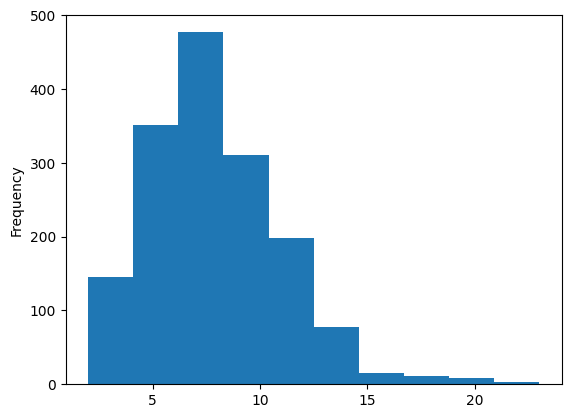

In [8]:
profanity['text_length'] = profanity['text'].apply(lambda x : len(x.replace(' ', '')))
profanity['text_length'].plot(kind = 'hist')

In [9]:
def ends_with_hard_consonant(s):
    hard_consonants = {'b', 'c', 'd', 'g', 'k', 'p', 'q', 't'}
    s = s.rstrip()
    return len(s) > 0 and s[-1].lower() in hard_consonants

profanity['hard_or_not'] = profanity['text'].apply(ends_with_hard_consonant)
profanity.head()


,text,canonical_form_1,canonical_form_2,canonical_form_3,category_1,category_2,category_3,severity_rating,severity_description,text_length,hard_or_not
0,69,69,NaN,NaN,sexual anatomy / sexual acts,NaN,NaN,1.0,Mild,2,False
1,@55,ass,NaN,NaN,sexual anatomy / sexual acts,NaN,NaN,1.0,Mild,3,False
2,@ssfcker,fuck,ass,NaN,sexual anatomy / sexual acts,sexual orientation / gender,NaN,2.8,Severe,8,False
3,@ssfucker,fuck,ass,NaN,sexual anatomy / sexual acts,sexual orientation / gender,NaN,2.8,Severe,9,False
4,@ssfvcker,fuck,ass,NaN,sexual anatomy / sexual acts,sexual orientation / gender,NaN,2.4,Strong,9,False


<AxesSubplot:xlabel='category_1'>

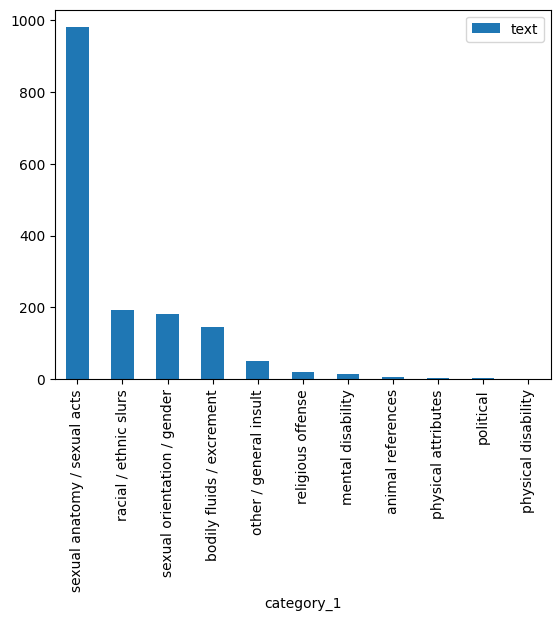

In [10]:
profanity[['category_1', 'text']].groupby('category_1').count().reset_index().sort_values('text', ascending= False).plot(kind = 'bar', x = 'category_1', y= 'text')

In [11]:
profanity['hard_or_not'].mean()

0.3072590738423029

In [12]:
pd.Series(profanity['canonical_form_1'].unique()).apply(ends_with_hard_consonant).mean()

0.3319672131147541

In [13]:
#finds the words that compound to other words and check their hard consenants
pd.Series(pd.concat([profanity['canonical_form_1'], profanity['canonical_form_2']], ignore_index = True).dropna().unique()).apply(ends_with_hard_consonant).mean()

0.3386454183266932